## Introducción a CNNs

### Referencias
- LeCun, Y., Bengio, Y. and Hinton, G., 2015. [Deep Learning](https://www.nature.com/articles/nature14539). nature, 521(7553), pp.436-444.
- [Ignite documentation](https://pytorch-ignite.ai/)
- [PyTorch tutorials](https://pytorch.org/tutorials/) 
- [torchmetrics examples](https://torchmetrics.readthedocs.io/en/stable/pages/quickstart.html)
- [visdom](https://github.com/fossasia/visdom)


![pytorch cheatsheet](./figs/pytorch-cheat.jpeg "pytorch cheatsheet")

Figure from [pytorch forum](https://discuss.pytorch.org/t/pytorch-cheat-sheet/72016)

### Que pasos debemos seguir para entrenar una CNN?
- Cargar datos, transformarlos en formato necesario para pytorch. $t_{train}$ va a tener transformaciones diferentes a $t_{test}$, por que? 
- A los datos de entrenamiento debemos dividirlos una vez mas para usar elementos de validación durante el entrenamiento.
- Definir arquitectura de nuestra red (Ver models.py)
- Definir métodos funciones de error, optimizador y métricas de evaluación.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision.datasets import MNIST
from torchvision.models import resnet18
from torchvision.transforms import Compose, Normalize, ToTensor
from sklearn.model_selection import KFold
import numpy as np
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage

### Carga de datos

In [2]:


from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data
import PIL

transforms_train = [
    tfs.RandomHorizontalFlip(p=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0)),
    tfs.Resize((64, 64)),
    tfs.Grayscale(1),
    tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
    tfs.ToTensor(),
]

transforms_test = [
    tfs.RandomHorizontalFlip(p=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0)),
    tfs.Resize((64, 64)),
    tfs.Grayscale(1),
    tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
    tfs.ToTensor(),
]

train_dataset = datasets.ImageFolder(
    "../data/train/", transform=tfs.Compose(transforms_train)
)

test_dataset = datasets.ImageFolder(
    "../data/test/", transform=tfs.Compose(transforms_test)
)

## Ahora tenemos que definir modelo, función de error, optimizador, etc.


In [3]:
import torch.optim as optim
from torch import nn
from models import _C
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
import torch.nn.functional as F
import torch
from aux import create_plot_window
import numpy as np

from ignite.contrib.handlers.tensorboard_logger import (
    global_step_from_engine,
    GradsHistHandler,
    GradsScalarHandler,
    TensorboardLogger,
    WeightsHistHandler,
    WeightsScalarHandler,
)

### Que dispositivo tenemos disponible?

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo disponible: {device}')

Dispositivo disponible: cuda


### Como es nuestro modelo?

In [5]:
# %load models.py
from torch import nn


class _C(nn.Module):
    """Classifier class"""

    def __init__(self, input_h_w=28):
        super(_C, self).__init__()
        self.input_height = input_h_w
        self.input_width = input_h_w
        self.input_dim = 1
        self.output_dim = 11

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, self.output_dim),
            nn.Softmax(1),
        )
        # utils.initialize_weights(self)

    def forward(self, input_):
        x = self.conv(input_)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)

        return x


In [6]:
def initialize():
    '''Funcion de inicialización. Creamos el modelo, definimos el optimizador y la función de perdida'''
    model = _C(input_h_w=64).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.CrossEntropyLoss()

    return model, optimizer, criterion

In [7]:
def setup_dataflow(dataset, train_idx, val_idx):
    ''' Funcion de inicialización para el dataset '''
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler, drop_last=True)
    val_loader = DataLoader(dataset, batch_size=64, sampler=val_sampler, drop_last=True)

    return train_loader, val_loader

In [8]:
from datetime import datetime

In [9]:
from torch.utils.tensorboard import SummaryWriter


#### Vamos a ver como usar ignite para entrenamiento supervisado, no se olviden de ver el dashboard the TensorBoard en [http://localhost:6006/](http://localhost:6006/)

#### en una consola externa, en la carpeta Day-x ejecutar: 
##### tensorboard --logdir=./output --port 6006  --host 0.0.0.0 --load_fast=false

In [10]:
def train_model(train_loader, val_loader, max_epochs=20, mode='training'):

    train_results = []
    val_results = []

    model, optimizer, criterion = initialize()

    now = datetime.now()
    logdir = "output/" + now.strftime("%Y%m%d-%H%M%S") + "/"
    writer = SummaryWriter(log_dir=logdir, flush_secs=1)

    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    evaluator = create_supervised_evaluator(model, metrics={"Accuracy": Accuracy(), "Loss": Loss(criterion)}, device=device,)

    
    

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics.copy()
        train_results.append(metrics)
        print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['Accuracy']:.2f} Avg loss: {metrics['Loss']:.2f}")
        

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics.copy()
        val_results.append(metrics)
        
        writer.add_scalars(f'{mode}/Accuracy',{'val':val_results[trainer.state.epoch - 1]['Accuracy'],
                                         'train':train_results[trainer.state.epoch - 1]['Accuracy']}, trainer.state.epoch)
        
        writer.add_scalars(f'{mode}/Loss',{'val':val_results[trainer.state.epoch - 1]['Loss'],
                                         'train':train_results[trainer.state.epoch - 1]['Loss']}, trainer.state.epoch)


    trainer.run(train_loader, max_epochs=max_epochs)
    writer.close()


    return model, train_results, val_results

## Particionamos los datos en Train/Val

In [11]:
splits = data.random_split(train_dataset, [867, 96])
train_idx, val_idx = splits[0].indices, splits[1].indices

## Entrenamos nuestro modelo

In [12]:
train_loader, val_loader = setup_dataflow(train_dataset, train_idx, val_idx)
final_model, train_results, val_results = train_model(train_loader, val_loader, 100)

Training Results - Epoch[1] Avg accuracy: 0.21 Avg loss: 2.33
Training Results - Epoch[2] Avg accuracy: 0.65 Avg loss: 2.12
Training Results - Epoch[3] Avg accuracy: 0.74 Avg loss: 1.85
Training Results - Epoch[4] Avg accuracy: 0.76 Avg loss: 1.81
Training Results - Epoch[5] Avg accuracy: 0.76 Avg loss: 1.79
Training Results - Epoch[6] Avg accuracy: 0.77 Avg loss: 1.78
Training Results - Epoch[7] Avg accuracy: 0.78 Avg loss: 1.78
Training Results - Epoch[8] Avg accuracy: 0.82 Avg loss: 1.74
Training Results - Epoch[9] Avg accuracy: 0.83 Avg loss: 1.72
Training Results - Epoch[10] Avg accuracy: 0.83 Avg loss: 1.72
Training Results - Epoch[11] Avg accuracy: 0.82 Avg loss: 1.73
Training Results - Epoch[12] Avg accuracy: 0.83 Avg loss: 1.72
Training Results - Epoch[13] Avg accuracy: 0.83 Avg loss: 1.72
Training Results - Epoch[14] Avg accuracy: 0.86 Avg loss: 1.70
Training Results - Epoch[15] Avg accuracy: 0.84 Avg loss: 1.72
Training Results - Epoch[16] Avg accuracy: 0.85 Avg loss: 1.70
T

## 

### Guardamos los pesos de la red

In [13]:
torch.save(final_model.state_dict(), "./weights/classifier.pkl")

### Cargamos los pesos existentes

In [14]:
final_model = _C(input_h_w=64).to(device)
final_model.load_state_dict(torch.load("./weights/classifier.pkl"))

<All keys matched successfully>

## Ploteamos las graficas de la función de perdida y del Accuracy

In [15]:
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

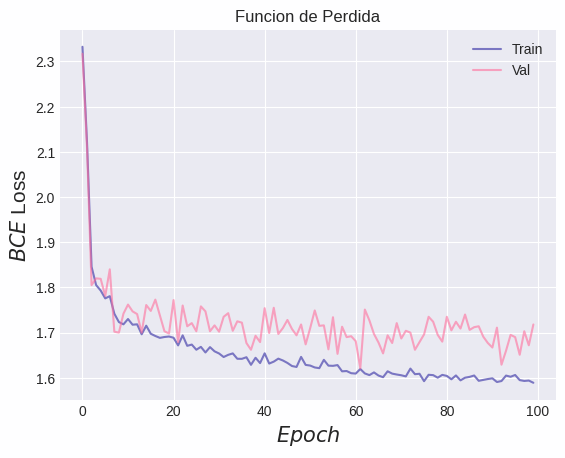

In [16]:
lossses_train = [t['Loss'] for t in train_results]
lossses_val = np.round([t['Loss'] for t in val_results], 3)

plt.plot(range(np.shape(lossses_train)[0]),lossses_train, '-', label='Train')
plt.plot(range(np.shape(lossses_val)[0]),lossses_val, '-', label='Val')
plt.title('Funcion de Perdida')
plt.xlabel('$Epoch$', fontsize=15)
plt.ylabel('$BCE$ Loss', fontsize=15)
plt.legend()

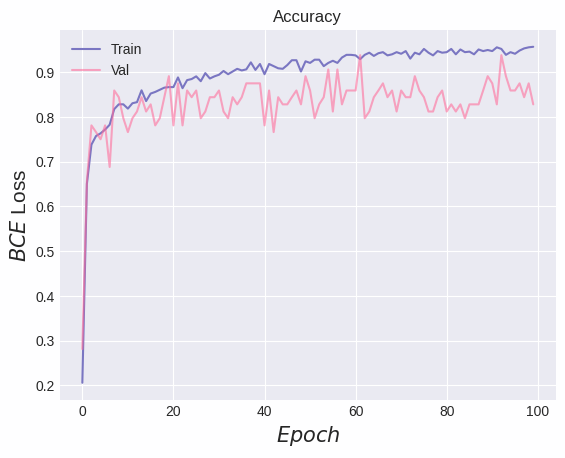

In [17]:
acc_train = [t['Accuracy'] for t in train_results]
acc_val = np.round([t['Accuracy'] for t in val_results], 3)

plt.plot(range(np.shape(acc_train)[0]),acc_train, '-', label='Train')
plt.plot(range(np.shape(acc_val)[0]),acc_val, '-', label='Val')
plt.title('Accuracy')
plt.xlabel('$Epoch$', fontsize=15)
plt.ylabel('$BCE$ Loss', fontsize=15)
plt.legend()

## Evaluamos nuestro modelo con la porción de datos de 'Test'

In [18]:
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=True)

### Matriz de confusión

In [19]:
import torchnet

confusion_matrix = torchnet.meter.ConfusionMeter(11, normalized=True)

for ii, data_ in enumerate(test_loader):
    input_, label = data_
    val_input = input_.to(device)  # .cuda()
    val_label = label.type(torch.LongTensor).to(device)  # .cuda()
    score = final_model(val_input)
    confusion_matrix.add(score.data.squeeze(), label.type(torch.LongTensor))

np.set_printoptions(precision=3)
print(confusion_matrix.conf)


[[ 9  0  0  0  0  0  0  0  0  0  0]
 [ 0 81  3  0  0  0  0  0  0  1  2]
 [ 0  0 24  0  1  0  0  0  1  0  0]
 [ 0  0  0  9  0  0  0  0  0  5  0]
 [ 0  0  0  0 15  0  0  0  2  3  0]
 [ 0  0  0  1  2  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 15  0  0  0  0]
 [ 1  1  0  0  0  0  0 11  0  4  0]
 [ 0  0  1  0  1  0  0  0 17  0  1]
 [ 0  0  0  3  1  0  0  6  0 91  0]
 [ 1  0  0  0  1  0  0  1  0  0  3]]


### Recall, F1-Score, Precision

In [20]:
from aux import iterations_test
from sklearn import metrics

y_real, y_pred = iterations_test(final_model, test_loader, device)
print(metrics.classification_report(np.array(y_pred), np.array(y_real)))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.97      0.98      0.97        86
           2       0.88      0.82      0.85        28
           3       0.57      0.89      0.70         9
           4       0.70      0.70      0.70        20
           5       0.00      0.00      0.00         0
           6       0.88      0.93      0.90        15
           7       0.59      0.53      0.56        19
           8       0.75      0.83      0.79        18
           9       0.92      0.86      0.89       108
          10       0.67      0.67      0.67         6

    accuracy                           0.86       319
   macro avg       0.71      0.73      0.72       319
weighted avg       0.87      0.86      0.86       319



/home/pablo/miniconda3/envs/curso_esp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pablo/miniconda3/envs/curso_esp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pablo/miniconda3/envs/curso_esp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Validación cruzada

In [21]:
dataset = ConcatDataset([train_dataset, test_dataset])

In [22]:
num_folds = 5
splits = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [23]:
results_per_fold = []

for fold_idx, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    nro_fold = fold_idx + 1
    print('Fold {}'.format(nro_fold))
    

    train_loader, val_loader = setup_dataflow(dataset, train_idx, val_idx)
    model, train_results, val_results = train_model(train_loader, val_loader, mode='Fold')
    results_per_fold.append([train_results, val_results])

Fold 1
Training Results - Epoch[1] Avg accuracy: 0.62 Avg loss: 2.19
Training Results - Epoch[2] Avg accuracy: 0.67 Avg loss: 1.97
Training Results - Epoch[3] Avg accuracy: 0.73 Avg loss: 1.86
Training Results - Epoch[4] Avg accuracy: 0.76 Avg loss: 1.80
Training Results - Epoch[5] Avg accuracy: 0.79 Avg loss: 1.77
Training Results - Epoch[6] Avg accuracy: 0.80 Avg loss: 1.76
Training Results - Epoch[7] Avg accuracy: 0.80 Avg loss: 1.75
Training Results - Epoch[8] Avg accuracy: 0.81 Avg loss: 1.74
Training Results - Epoch[9] Avg accuracy: 0.82 Avg loss: 1.73
Training Results - Epoch[10] Avg accuracy: 0.82 Avg loss: 1.73
Training Results - Epoch[11] Avg accuracy: 0.84 Avg loss: 1.72
Training Results - Epoch[12] Avg accuracy: 0.84 Avg loss: 1.71
Training Results - Epoch[13] Avg accuracy: 0.84 Avg loss: 1.71
Training Results - Epoch[14] Avg accuracy: 0.84 Avg loss: 1.71
Training Results - Epoch[15] Avg accuracy: 0.86 Avg loss: 1.69
Training Results - Epoch[16] Avg accuracy: 0.87 Avg loss:

In [24]:
acc_sum = 0
for n_fold in range(len(results_per_fold)):
  current_fold = results_per_fold[n_fold]
  print(f"Validation Results - Fold[{n_fold + 1}] Avg accuracy: {current_fold[1][2]['Accuracy']:.2f} Avg loss: {current_fold[1][2]['Loss']:.2f}")
  acc_sum += current_fold[1][2]['Accuracy']

folds_mean = acc_sum/num_folds
print(f"Model validation average for {num_folds}-folds: {folds_mean :.2f}")

Validation Results - Fold[1] Avg accuracy: 0.73 Avg loss: 1.85
Validation Results - Fold[2] Avg accuracy: 0.75 Avg loss: 1.83
Validation Results - Fold[3] Avg accuracy: 0.75 Avg loss: 1.83
Validation Results - Fold[4] Avg accuracy: 0.70 Avg loss: 1.85
Validation Results - Fold[5] Avg accuracy: 0.71 Avg loss: 1.86
Model validation average for 5-folds: 0.73


##  Ejercicios

- Visualizar las funciones de perdida para distintos learning rates. Qué observan en los gráficos?
- Visualizar las funciones de perdida para distintos tamanos de lotes. 
- Visualizar un grupo de elementos del grupo de evaluacion con la clasificación y su puntaje respectivo.
- Comparar metricas de red entrenada en 10, 50 y 100 epochs. Qué diferencias observan?
- Re-entrenar un modelo preentrando `from torchvision import  models` para clasificacion, comparar sus resultados.